In [1]:
import pandas as pd
from glob import glob
import config
import utils
from importlib import reload
from os.path import join as j
import numpy as np
import json

reload(config)
reload(utils)

<module 'utils' from '/home/dauin_user/gattanasio/CTS/CTS/utils.py'>

# Classification

In [2]:
CLASSIFIERS = {str(c) for c in config.HPARAMS.keys()}
print(CLASSIFIERS)

DETERMINISTIC = {str(c) for c in config.DETERMINISTIC}
print(DETERMINISTIC)

NUM_CLASSES = {2, 3}

CRYPTO = {str(c) for c in config.Cryptocurrency}
print(CRYPTO)

In [4]:
RESULTS_DIR = "out_50_0.0"

CLASS_RESULTS = j(RESULTS_DIR, "metrics")
TRADING_RESULTS = j(RESULTS_DIR, "trading")

In [5]:
def process_classification_results(data, num_classes):
    d = {
        "F1_macro": data.loc["f1-score", "macro avg"],
        "F1_weighted": data.loc["f1-score", "weighted avg"],
        "Accuracy": data.loc["precision", "accuracy"],
    }
    
    if num_classes == 2:
        d["F1_O"] = data.loc["f1-score", "1"]
        d["Precision_O"] = data.loc["precision", "1"]
        d["Recall_O"] = data.loc["recall", "1"]
    else:
        d["F1_O"] = data.loc["f1-score", ["-1", "1"]].mean()
        d["Precision_O"] = data.loc["precision", ["-1", "1"]].mean()
        d["Recall_O"] = data.loc["recall", ["-1", "1"]].mean()
    
    return d

In [8]:
results = list()

# read and process deterministic models
for model in list(DETERMINISTIC) + ["HE"]:
    for n_class in NUM_CLASSES:
        for crypto in CRYPTO:
            filename = utils.get_filename(crypto, model, n_class, None)
            res = pd.read_csv(j(CLASS_RESULTS, filename), index_col="metric")
            d = process_classification_results(res, n_class)
            d["classifier"] = model
            d["n_class"] = n_class
            d["crypto"] = crypto
            results.append(d)
            
deterministic = pd.DataFrame(results)

results = list()

# read and process non-deterministic models: average across seeds (random initializations)
for model in list(CLASSIFIERS - DETERMINISTIC) + ["LSTM"]:
    for n_class in NUM_CLASSES:
        for crypto in CRYPTO:
            for seed in range(10):
                filename = utils.get_filename(crypto, model, n_class, seed)
                
                if model == "LSTM":
                    res = pd.read_csv(j(CLASS_RESULTS, filename), index_col=0)
                    res.index.name = "metric"
                else:
                    res = pd.read_csv(j(CLASS_RESULTS, filename), index_col="metric")
                
                d = process_classification_results(res, n_class)
                d["classifier"] = model
                d["n_class"] = n_class
                d["crypto"] = crypto
                d["seed"] = seed
                results.append(d)
                
non_deterministic_mean = pd.DataFrame(results).groupby(["classifier", "n_class", "crypto"]).mean().drop("seed", axis=1).reset_index()
non_deterministic_std = pd.DataFrame(results).groupby(["classifier", "n_class", "crypto"]).std().drop("seed", axis=1).reset_index()

In [9]:
deterministic.pivot_table(
    index="classifier", columns=["n_class", "crypto"]
).drop(
    "Accuracy", axis=1
).to_csv(j(RESULTS_DIR, "comparison_det.csv"))

In [10]:
non_deterministic_mean.pivot_table(
    index="classifier", columns=["n_class", "crypto"]
).drop(
    "Accuracy", axis=1
).to_csv(j(RESULTS_DIR, "comparison_nondet_mean.csv"))

non_deterministic_std.pivot_table(
    index="classifier", columns=["n_class", "crypto"]
).drop(
    "Accuracy", axis=1
).to_csv(j(RESULTS_DIR, "comparison_nondet_std.csv"))

# Trading

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
sns.set_theme("notebook", style="white", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [13]:
EQUITIES_FOLDER = j(RESULTS_DIR, "portfolio_simulations_equity_trend")

### Equities with three classes

In [45]:
n_class = 3

equities = list()
for classifier in list(CLASSIFIERS - DETERMINISTIC) + ["LSTM"]:
    for seed in range(10):
        filename = utils.get_equity_filename(classifier, n_class, seed)
        df = pd.read_csv(j(EQUITIES_FOLDER, filename), parse_dates=["Date"], infer_datetime_format=True)
        df["seed"] = seed
        df["classifier"] = classifier
        equities.append(df)
        
for classifier in list(DETERMINISTIC) + ["HE"]:
    filename = utils.get_equity_filename(classifier, n_class, None)
    df = pd.read_csv(j(EQUITIES_FOLDER, filename), parse_dates=["Date"], infer_datetime_format=True)
    df["classifier"] = classifier
    equities.append(df)
        
equities = pd.concat(equities, axis=0)

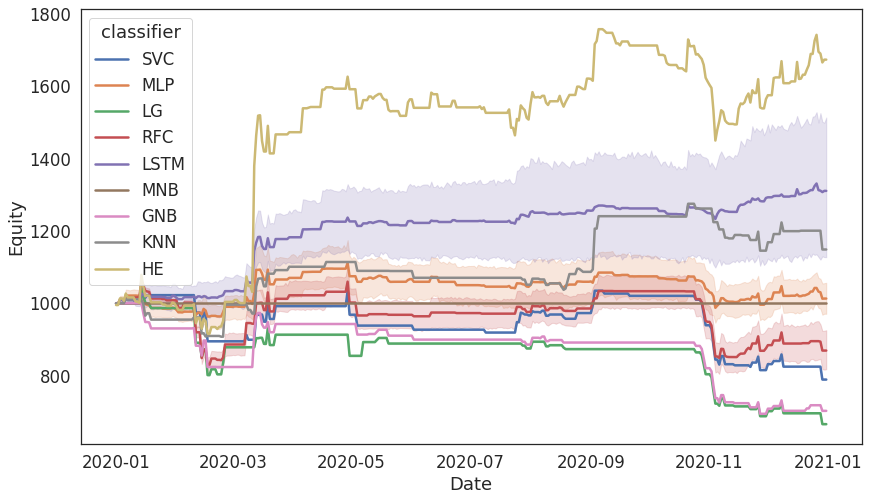

In [46]:
plt.figure(figsize=(14,8))
sns.lineplot(data=equities, x="Date", y="Equity", hue="classifier")
plt.savefig(j(RESULTS_DIR, "chart_equity_3_classes.pdf"))

### Equities with 2 classes (Overreaction/Non overreaction)

In [47]:
n_class = 2

equities = list()
for classifier in list(CLASSIFIERS - DETERMINISTIC) + ["LSTM"]:
    for seed in range(10):
        filename = utils.get_equity_filename(classifier, n_class, seed)
        df = pd.read_csv(j(EQUITIES_FOLDER, filename), parse_dates=["Date"], infer_datetime_format=True)
        df["seed"] = seed
        df["classifier"] = classifier
        equities.append(df)
        
for classifier in list(DETERMINISTIC) + ["HE"]:
    filename = utils.get_equity_filename(classifier, n_class, None)
    df = pd.read_csv(j(EQUITIES_FOLDER, filename), parse_dates=["Date"], infer_datetime_format=True)
    df["classifier"] = classifier
    equities.append(df)
        
equities = pd.concat(equities, axis=0)

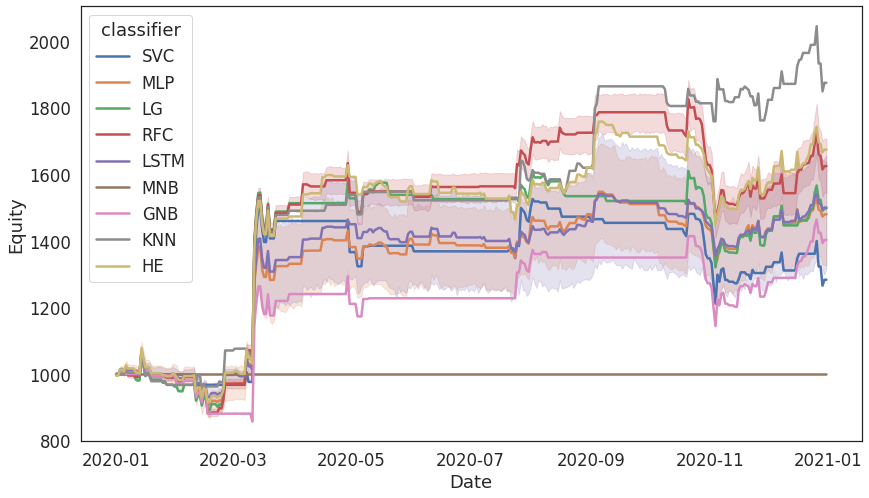

In [48]:
plt.figure(figsize=(14,8))
sns.lineplot(data=equities, x="Date", y="Equity", hue="classifier")
plt.savefig(j(RESULTS_DIR, "chart_equity_2_classes.pdf"))

## Trading tables

In [40]:
results = list()
for classifier in list(DETERMINISTIC) + ["HE"]:
    for n_class in NUM_CLASSES:
        filename = utils.get_trading_stats_filename(classifier, n_class, None)
        with open(j(RESULTS_DIR, "trading", filename)) as fp:
            d = json.load(fp)
            d["classifier"] = classifier
            d["n_class"] = n_class
            results.append(d)
            

non_det_res = list()

for classifier in list(CLASSIFIERS - DETERMINISTIC) + ["LSTM"]:
    for n_class in NUM_CLASSES:        
        for seed in range(10):
            filename = utils.get_trading_stats_filename(classifier, n_class, seed)
            with open(j(RESULTS_DIR, "trading", filename)) as fp:
                d = json.load(fp)
                d["classifier"] = classifier
                d["n_class"] = n_class
                non_det_res.append(d)
            

non_deterministic_mean = pd.DataFrame(non_det_res).groupby(["classifier", "n_class"]).mean().reset_index()
non_deterministic_std = pd.DataFrame(non_det_res).groupby(["classifier", "n_class"]).std().reset_index()
            
results_det = pd.DataFrame(results)

final = pd.concat([results_det, non_deterministic_mean], axis=0).set_index("classifier").sort_values("n_class")
final.to_csv(j(RESULTS_DIR, "comparison_trading_stats.csv"))
non_deterministic_std.set_index("classifier").sort_values("n_class").to_csv(j(RESULTS_DIR, "comparison_trading_stats_nondet_std.csv"))

final

,long_pos,short_pos,total_pos,success_pos,success_perc,long_return,long_return_mean,long_return_std,short_return,short_return_mean,short_return_std,total_return,days,avg allocations,n_class
classifier,,,,,,,,,,,,,,,
MNB,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,348.0,0.000000,2
RFC,95.0,76.0,171.0,102.8,60.113268,1.824125,0.019201,0.034395,0.782253,0.010321,0.077173,2.606378,348.0,0.986494,2
MLP,80.0,82.2,162.2,93.7,57.861757,1.211657,0.015177,0.030081,0.431037,0.005066,0.053273,1.642694,348.0,1.228448,2
LSTM,93.8,105.6,199.4,112.7,58.883961,1.380652,0.014542,0.028846,0.613715,0.007801,0.054535,1.994367,348.0,1.648563,2
SVC,50.0,39.0,89.0,45.0,50.561798,0.833240,0.016665,0.037555,0.386121,0.009901,0.081707,1.219361,348.0,0.606322,2
HE,170.0,192.0,362.0,206.0,56.906077,2.515517,0.014797,0.030129,1.100836,0.005734,0.053213,3.616353,348.0,3.000000,2
LG,83.0,103.0,186.0,106.0,56.989247,1.495368,0.018016,0.036365,0.952535,0.009248,0.066190,2.447903,348.0,1.109195,2
KNN,66.0,66.0,132.0,79.0,59.848485,1.024722,0.015526,0.032460,0.427378,0.006475,0.049763,1.452100,348.0,0.942529,2
GNB,66.0,56.0,122.0,72.0,59.016393,1.344132,0.020366,0.036682,0.534321,0.009541,0.085781,1.878453,348.0,0.666667,2


### Create zip folder

In [50]:
import shutil

shutil.make_archive(RESULTS_DIR, 'zip', RESULTS_DIR)

'/home/dauin_user/gattanasio/CTS/CTS/out_50_0.0.zip'